# Import basic libraries and dependencies

In [1]:
import sys
import importlib

sys.path.append('./modules')
from config import English, Bengali

# Set a language

In [2]:
LANG = English # English, Bengali

# 1. Data Preparation

In [6]:
# import libraries and dependencies
import preprocessing
import utils
importlib.reload(preprocessing)
from preprocessing import raw_preprocess, split_train_test

## 1.1. Preprocess data for sentencepiece

In [7]:
# preprocess raw data to get a list of sentences.
sentences = raw_preprocess(LANG)

# write the sentences into a file, each sentence on one line.
with open(f'data/{LANG.name}/preprocessed.txt', 'w') as f:
    for sentence in sentences:
        f.write(f'{sentence}\n')

utils.print_length_statistics(sentences)

Num. of sentences = 11717
Avg. length = 113.63471878467185
Std. dev. of the length = 152.39452707784676
Maximum length = 2316
Minimum length = 1


## 1.2. Train/test split

In [8]:
# split data to train and test.
train, test = split_train_test(sentences, LANG)

# write train and test data into corresponding files.
train_path = f'data/{LANG.name}/train.txt'
test_path = f'data/{LANG.name}/test.txt'

with open(train_path, 'w') as f:
    f.write('\n'.join(train))
with open(test_path, 'w') as f:
    f.write('\n'.join(test))

# 2. Subword segmentation

For English. we use a small subword vocabulary size of 500 and a large subword vocabulary size of 1500. For Bengali, these numbers are 800 and 1700.

In [11]:
# import libraries and dependencies
import segmentation
importlib.reload(segmentation)
from segmentation import train_segmentation, encode_text_file, decode_text_file
from config import seg_profiles

In [10]:
seg_profiles[LANG.name]

[SegmentationConf(id='s1', vocab_size=None, model_type='char'),
 SegmentationConf(id='s2', vocab_size=800, model_type='bpe'),
 SegmentationConf(id='s3', vocab_size=1700, model_type='bpe')]

In [ ]:
for seg in seg_profiles[LANG.name]:
    # train segmentation on the train data
    spm1 = train_segmentation(
        text_file=train_path, 
        LANG=LANG, 
        vocab_size=seg.vocab_size, 
        model_type=seg.model_type)
  
    encoded_file = f'data/{LANG.name}/segmentation/{seg.id}.txt'
    encode_text_file(text_file=train_path, model_path=spm1, output_file=encoded_file)
    
    decoded_file = f'data/{LANG.name}/segmentation/{seg.id}_decoded.txt'
    decode_text_file(text_file=encoded_file, model_path=spm1, output_file=decoded_file)
    
    # test it on the test data
    encoded_file = f'data/{LANG.name}/segmentation/{seg.id}_test.txt'
    encode_text_file(text_file=test_path, model_path=spm1, output_file=encoded_file)
    
    decoded_file = f'data/{LANG.name}/segmentation/{seg.id}_decoded_test.txt'
    decode_text_file(text_file=encoded_file, model_path=spm1, output_file=decoded_file)

# 3. Language Model

## Baseline

In [12]:
from config import baseline_conf
baseline_conf

TrainingConf(hidden=40, rand_seed=1, debug=2, bptt=4, n_class=9999)

Executing the following cell will delete the already trained language models. To simply see the perplexity of the trained models, skip this cell and execute the next one.

In [ ]:
for seg in seg_profiles[LANG.name]:
    # Hyper parameters
    hidden = baseline_conf.hidden
    rand_seed = baseline_conf.rand_seed
    debug = baseline_conf.debug
    bptt = baseline_conf.bptt
    n_class = baseline_conf.n_class

    # Parameters
    model_path = f'models/rnnlm/{LANG.name}/{seg.id}_baseline'
    train_path = f'../../../../data/{LANG.name}/segmentation/{seg.id}.txt'
    valid_path = f'../../../../data/{LANG.name}/segmentation/{seg.id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $n_class

The validation perplexities of the baseline models are:

In [13]:
for seg in seg_profiles[LANG.name]:
    model_path = f'models/rnnlm/{LANG.name}/{seg.id}_baseline'
        
    # read output and print perplexity
    with open(f'{model_path}/model.output.txt', 'r') as f:
        output = f.read()
        pp = output.split()[-1]
        print(f'Baseline {LANG.name}-{seg.id} validation perplexity: {pp}')

Baseline bn-s1 validation perplexity: 7.368929
Baseline bn-s2 validation perplexity: 94.109742
Baseline bn-s3 validation perplexity: 176.930043


## Experiments

In [15]:
import pickle
import itertools

In [16]:
# experimented results are kept in a file
grid_result_file = f'experiments/{LANG.name}/task3_grid_search.pickle'
# grid_results stores the results in memory
grid_results = {}

# import previous results if exists

with open(grid_result_file, 'rb') as f:
    previous_results = pickle.load(f)
    grid_results.update(previous_results)

grid_results

{('bn', 's1', 200, 4, 1700): 5.198053,
 ('bn', 's2', 200, 4, 1700): 77.243412,
 ('bn', 's3', 200, 4, 1700): 170.361866}

In [ ]:
hidden_choices = [5, 20, 40, 70, 100, 150, 200]
bptt_choices = [0, 1, 3, 5]
class_choices = [10, 100, 1501]
rand_seed = 1
debug = 2

for seg, hidden, bptt, _class in itertools.product(
    seg_profiles[LANG.name], hidden_choices, bptt_choices, class_choices):

    if (LANG.name, seg.id, hidden, bptt, _class) in grid_results:
        print(f'skip {LANG.name} {seg.id} {hidden} {bptt} {_class}')
        continue

    # Parameters
    model_path = f'models/rnnlm/{LANG.name}/{seg.id}'
    train_path = f'../../../../data/{LANG.name}/segmentation/{seg.id}.txt'
    valid_path = f'../../../../data/{LANG.name}/segmentation/{seg.id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $_class \
        2> error.txt

    # read output extract validation perplexity
    with open(f'{model_path}/model.output.txt', 'r') as f:
        output = f.read()
        pp = float(output.split()[-1])
        grid_results[(LANG.name, seg.id, hidden, bptt, _class)] = pp

    # write current results to file
    with open(grid_result_file, 'wb') as f:
        pickle.dump(grid_results, f)

In [17]:
import visualisation 

if LANG == English:
    visualisation.plot_grid_results(English, grid_results)

The optimal configurations of hyperparameters for each vocabulary size are:

In [28]:
for seg in seg_profiles[LANG.name]:
    results = dict((k, v) for (k, v) in grid_results.items() if k[1] == seg.id)
    print(f"{seg.id}: {min(results, key=results.get)}")

s1: ('bn', 's1', 200, 4, 1700)
s2: ('bn', 's2', 200, 4, 1700)
s3: ('bn', 's3', 200, 4, 1700)


In [ ]:
# train and save LMs for the optimal configurations
importlib.reload(config)
from config import optimal_conf

for id, (hidden, rand_seed, debug, bptt, n_class) in \
    enumerate(optimal_conf[LANG.name], start=1):
    
    seg_id = f's{id}'

    # paths
    model_path = f'models/rnnlm/{LANG.name}/{seg_id}_optimal'
    train_path = f'../../../../data/{LANG.name}/segmentation/{seg_id}.txt'
    valid_path = f'../../../../data/{LANG.name}/segmentation/{seg_id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $n_class

# 4. Text Generation

In [1]:
from config import SEG_MODELS_PATH

In [41]:
for seg in seg_profiles[LANG.name]:
    gen_folder = f'data/{LANG.name}/generation/{seg.id}'
    # path to LM file
    language_model_file = f'models/rnnlm/{LANG.name}/{seg.id}_optimal/model'
    # path to segmentation file
    if seg.model_type == 'char':
        seg_model_file = f'{SEG_MODELS_PATH}/{LANG.name}/spm_{seg.model_type}.model'
    else:
        seg_model_file = f'{SEG_MODELS_PATH}/{LANG.name}/spm_{seg.model_type}_vocabsize-{seg.vocab_size}.model'
    
    # remove the text-generation folder
    !rm -rf $gen_folder \
        && mkdir $gen_folder
    
    for n_gen in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:
        # generate text using rnnlm
        gen_file = f'{gen_folder}/{n_gen}.txt'
        !rnnlm-0.3e/rnnlm \
                -rnnlm $language_model_file \
                -gen $n_gen \
                -debug 0 \
            > $gen_file
        
        # decode generated text using sentencepiece
        decoded_gen_file = f'{gen_folder}/{n_gen}_decoded.txt'
        decode_text_file(gen_file, seg_model_file, decoded_gen_file)

# 5. OOV comparison

In [7]:
import vocab_processing 
vocab_processing = importlib.reload(vocab_processing)
from vocab_processing import get_word_level_vocabulary, get_word_level_tokens, get_oov_rate

In [8]:
train_path = f'data/{LANG.name}/train.txt'
test_path = f'data/{LANG.name}/test.txt'

In [9]:
# get the training vocabulary on word-level
train_vocab = get_word_level_vocabulary(LANG, train_path)
# get the test tokens on word-level
test_tokens = get_word_level_tokens(LANG, test_path)
# compute and print OOV rate
oov_rate = get_oov_rate(train_vocab, test_tokens)
print(f'Original data\'s OOV rate: {oov_rate:.2%}')

Original data's OOV rate: 4.80%


## Augment vocabulary with generated data

In [12]:
oov_rates = []

for seg in seg_profiles[LANG.name]:
    gen_folder = f'data/{LANG.name}/generation/{seg.id}'
    oov_rates.append([])
    
    for n_gen in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:

        # obtain the vocabulary from the generated corpora
        decoded_gen_file = f'{gen_folder}/{n_gen}_decoded.txt'
        gen_vocab = get_word_level_vocabulary(LANG, decoded_gen_file)

        # compute the oov-rate on the augmented vocabulary
        augmented_oov_rate = get_oov_rate(train_vocab | gen_vocab, test_tokens)
        print(f'{LANG.name} {seg.id} {n_gen} OOV rate: {augmented_oov_rate:.2%}')
        oov_rates[-1].append(augmented_oov_rate)

en s1 10 OOV rate: 4.80%
en s1 100 OOV rate: 4.80%
en s1 1000 OOV rate: 4.80%
en s1 10000 OOV rate: 4.79%
en s1 100000 OOV rate: 4.64%
en s1 1000000 OOV rate: 3.92%
en s1 10000000 OOV rate: 2.96%
en s2 10 OOV rate: 4.80%
en s2 100 OOV rate: 4.80%
en s2 1000 OOV rate: 4.80%
en s2 10000 OOV rate: 4.71%
en s2 100000 OOV rate: 4.33%
en s2 1000000 OOV rate: 3.59%
en s2 10000000 OOV rate: 2.71%
en s3 10 OOV rate: 4.80%
en s3 100 OOV rate: 4.80%
en s3 1000 OOV rate: 4.80%
en s3 10000 OOV rate: 4.73%
en s3 100000 OOV rate: 4.49%
en s3 1000000 OOV rate: 3.81%
en s3 10000000 OOV rate: 2.93%


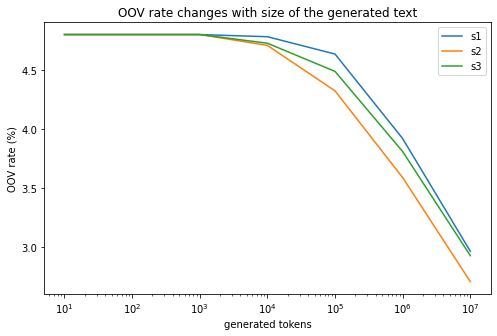

In [13]:
import visualisation
from visualisation import plot_oov_rates
from config import FIGURES_PATH

#plot_oov_rates(oov_rates)
plot_oov_rates(oov_rates, save_path=f'{FIGURES_PATH}/{LANG.name}/task5_oov_rates.png')

# 6. Analysis

TO DO 

In [82]:
import string

account_number = 'sdf23fsdf1@#vfb#'

final_account_number = account_number.translate(
    str.maketrans(string.punctuation, ' '*len(string.punctuation))
)

print(final_account_number)

sdf23fsdf1  vfb 


In [83]:
'ASbvSDBDsd323@#'.lower()

'asbvsdbdsd323@#'